In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time


import tqdm
from skimage.transform import resize,rotate
from skimage.color import rgb2gray

from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import *
from keras import backend as K
from keras.losses import *

from sklearn.model_selection import train_test_split
import tensorflow as tf

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

Using TensorFlow backend.


In [2]:
# Set some parameters
n_pixels = 128
channels = 1
path_train = 'train/'
path_test = 'test/'

In [3]:
train=pd.read_csv("train/train.csv")
print(train.shape)
train.head()

(4000, 2)


,id,rle_mask
0,575d24d81d,NaN
1,a266a2a9df,5051 5151
2,75efad62c1,9 93 109 94 210 94 310 95 411 95 511 96 612 96...
3,34e51dba6a,48 54 149 54 251 53 353 52 455 51 557 50 659 4...
4,4875705fb0,1111 1 1212 1 1313 1 1414 1 1514 2 1615 2 1716...


In [4]:
sample=pd.read_csv("sample_submission.csv")
print(sample.shape)
sample.head()

(18000, 2)


,id,rle_mask
0,155410d6fa,1 1
1,78b32781d1,1 1
2,63db2a476a,1 1
3,17bfcdb967,1 1
4,7ea0fd3c88,1 1


In [5]:
depth=pd.read_csv("depths.csv")
print(depth.shape)
depth.head()

(22000, 2)


,id,z
0,4ac19fb269,306
1,1825fadf99,157
2,f59821d067,305
3,5b435fad9d,503
4,e340e7bfca,783


In [6]:
train_ids = train.id.values
test_ids = sample.id.values

In [7]:
resize_mode='constant'

# Get and resize train images and masks
X = np.zeros((len(train_ids), n_pixels, n_pixels, channels), dtype=np.uint8)
y = np.zeros((len(train_ids), n_pixels, n_pixels, 1), dtype=np.bool)
# print('Getting and resizing train images and masks ... ')
for n, id_ in tqdm.tqdm_notebook(enumerate(train_ids),total=len(train_ids)):
    path = path_train
    x = np.array(load_img(path + '/images/' + id_+".png",color_mode='grayscale'))
    x = resize(x, (n_pixels,n_pixels, channels), mode=resize_mode, 
               preserve_range=True,clip=True,anti_aliasing=False)
    X[n] = x
    mask = np.array(load_img(path + '/masks/' + id_+".png",color_mode='grayscale'))
    y[n] = resize(mask, (n_pixels,n_pixels,1), mode=resize_mode, 
                  preserve_range=True,clip=True,anti_aliasing=False)

print('Done!')


Done!


## TEST DATA

In [8]:
# Get and resize test images
X_test = np.zeros((len(test_ids),n_pixels,n_pixels,channels), dtype=np.uint8)
sizes_test = []
print('Getting and resizing test images ... ')
sys.stdout.flush()
for n, id_ in tqdm.tqdm_notebook(enumerate(test_ids), total=len(test_ids)):
    path = path_test
    x= np.array(load_img(path + '/images/' + id_+".png",color_mode='grayscale'))
    x = resize(x, (n_pixels,n_pixels, 1), mode=resize_mode, 
               preserve_range=True,clip=True,anti_aliasing=False)
    X_test[n] = x

print('Done!')

Getting and resizing test images ... 



Done!


## VALIDATION SPLIT AND STRATIFICATION

Calculating the salt coverage class

In [9]:
coverage=np.zeros((train_ids.shape[0],))
for i,name in tqdm.tqdm_notebook(enumerate(train_ids),total=train_ids.shape[0]):
    coverage[i]=np.sum(y[i,:,:,0])

train['coverage']=pd.Series(coverage)/y.shape[1]**2

print(train.shape)
train.head()


(4000, 3)


,id,rle_mask,coverage
0,575d24d81d,NaN,0.000000
1,a266a2a9df,5051 5151,0.507812
2,75efad62c1,9 93 109 94 210 94 310 95 411 95 511 96 612 96...,0.994507
3,34e51dba6a,48 54 149 54 251 53 353 52 455 51 557 50 659 4...,0.155029
4,4875705fb0,1111 1 1212 1 1313 1 1414 1 1514 2 1615 2 1716...,0.048401


In [10]:
def cov_to_class(val):    
    for i in range(0, 11):
        if val * 10 <= i :
            return i
        
train["coverage_class"] = train.coverage.apply(cov_to_class)

print(train.shape)
train.head()

(4000, 4)


,id,rle_mask,coverage,coverage_class
0,575d24d81d,NaN,0.000000,0
1,a266a2a9df,5051 5151,0.507812,6
2,75efad62c1,9 93 109 94 210 94 310 95 411 95 511 96 612 96...,0.994507,10
3,34e51dba6a,48 54 149 54 251 53 353 52 455 51 557 50 659 4...,0.155029,2
4,4875705fb0,1111 1 1212 1 1313 1 1414 1 1514 2 1615 2 1716...,0.048401,1


In [11]:
## coverage class numpy array
coverage=train.coverage_class.values
print(coverage.shape)

(4000,)


In [12]:
train.loc[train['coverage']==0].shape

(1562, 4)

In [13]:
p=np.ones((4000,))
for i in range(4000):
    p[i]=np.sum(X[i,:,:,:])/(128*128)

index=[]
for j,i in enumerate(p):
    if i==0:
        index.append(j)
        
        
print(len(index))
print(index)

80
[37, 57, 90, 121, 136, 143, 211, 218, 262, 270, 314, 506, 550, 638, 738, 995, 1084, 1394, 1436, 1478, 1567, 1609, 1614, 1623, 1629, 1646, 1695, 1698, 1743, 1773, 1834, 1839, 1842, 1894, 1923, 1928, 1938, 1957, 1986, 2008, 2057, 2192, 2293, 2391, 2393, 2454, 2477, 2521, 2677, 2713, 2725, 2771, 2785, 2799, 2838, 2852, 2882, 2939, 2953, 3015, 3036, 3107, 3206, 3233, 3281, 3362, 3426, 3432, 3502, 3533, 3536, 3640, 3647, 3673, 3684, 3736, 3746, 3779, 3966, 3986]


In [14]:
q=np.ones((18000,))
for i in range(18000):
    q[i]=np.sum(X_test[i,:,:,:])/(128*128)
    
indextest=[]
for j,i in enumerate(q):
    if i==0:
        indextest.append(j)
        
print(len(indextest))
print(indextest)

430
[67, 128, 137, 138, 172, 183, 220, 251, 273, 373, 377, 385, 404, 496, 513, 551, 638, 656, 665, 704, 837, 844, 854, 905, 915, 919, 954, 995, 1119, 1166, 1175, 1217, 1270, 1291, 1309, 1337, 1348, 1470, 1492, 1499, 1537, 1586, 1588, 1596, 1609, 1627, 1648, 1650, 1656, 1771, 1842, 1845, 1855, 1872, 1924, 1925, 2021, 2033, 2139, 2184, 2220, 2265, 2323, 2341, 2432, 2502, 2603, 2727, 2767, 2780, 2854, 2996, 3043, 3079, 3211, 3286, 3384, 3503, 3514, 3552, 3654, 3666, 3668, 3721, 3724, 3761, 3804, 3810, 3906, 3928, 3963, 4008, 4031, 4044, 4055, 4098, 4109, 4121, 4202, 4218, 4271, 4290, 4295, 4297, 4363, 4424, 4526, 4561, 4569, 4599, 4634, 4723, 4725, 4727, 4741, 4755, 4863, 4883, 4889, 4900, 4904, 4990, 5125, 5132, 5189, 5215, 5224, 5291, 5327, 5341, 5385, 5409, 5430, 5512, 5524, 5576, 5702, 5760, 5777, 5920, 6008, 6039, 6098, 6104, 6140, 6155, 6162, 6211, 6238, 6244, 6335, 6367, 6448, 6454, 6479, 6481, 6488, 6534, 6540, 6556, 6663, 6697, 6766, 6805, 6843, 6879, 6893, 6929, 6942, 6973, 7044

## AUGMENTATION

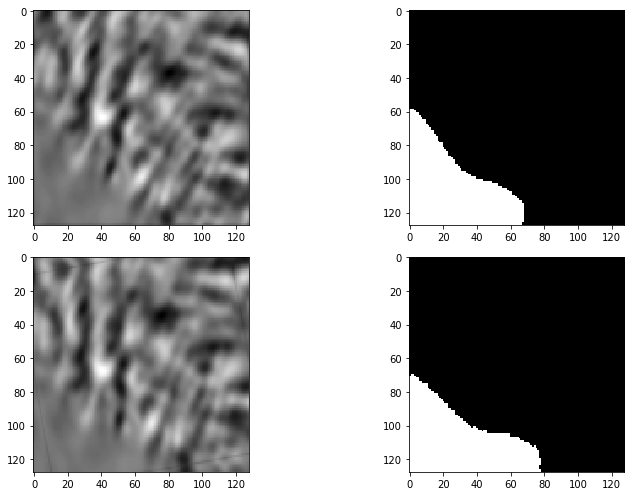

In [15]:
ind=3

p=rotate(X[ind,:,:,0].astype(np.uint8),angle=10,order=1,mode='reflect',
                clip=True,preserve_range=True)
q=rotate(y[ind,:,:,0].astype(np.uint8),angle=10,order=1,mode='reflect',
         clip=True,preserve_range=True)

plt.figure(figsize=(12,7))

plt.subplot(221)
plt.imshow(X[ind].reshape(128,128),cmap='gist_gray')
plt.subplot(222)
plt.imshow(y[ind].reshape(128,128),cmap='gist_gray')
plt.subplot(223)
plt.imshow(p.astype(np.uint8).reshape(128,128),cmap='gist_gray')
plt.subplot(224)
plt.imshow(q.astype(np.uint8).reshape(128,128),cmap='gist_gray')

plt.tight_layout()
plt.show()


In [16]:
def crop_rescale_image(image,mask,state,limit):
    np.random.seed(state)
    h,w=image.shape[0],image.shape[1]
    dy=int(h*limit)
    y0=np.random.randint(int(0.1*h),dy)
    y1=h-y0
    
    
    np.random.seed(state+5000)
    dx=int(w*limit)
    x0=np.random.randint(int(0.1*w),dx)
    x1=w-x0
    
    m='reflect'
#     print(y0,x0)
    cropped_image=resize(image[y0:y1,x0:x1,:],(h,w),mode=m,
                         preserve_range=True,anti_aliasing=False)
    cropped_mask=resize(mask[y0:y1,x0:x1,:],(h,w),mode=m,
                        preserve_range=True,anti_aliasing=False)

    
    return cropped_image,cropped_mask
    
def random_crop_rescale(X,y,limit):
    m=X.shape[0]
    processed_image=np.zeros(X.shape)
    processed_mask=np.zeros(y.shape)
    for i in range(m):
        processed_image[i,:,:,:],processed_mask[i,:,:,:]=crop_rescale_image(X[i,:,:,:],y[i,:,:,:],i,limit)
    
    return processed_image.astype(np.uint8),processed_mask.astype(np.uint8)


def rotate_grp(images,masks,ang):
    rotated_images=np.zeros((images.shape))
    rotated_masks=np.zeros((masks.shape))
    for i in range(images.shape[0]):
        rotated_images[i,:,:,0]=rotate(X[i,:,:,0].astype(np.uint8),angle=ang,order=1,mode='reflect',
                clip=True,preserve_range=True)
        rotated_masks[i,:,:,0]=q=rotate(y[ind,:,:,0].astype(np.uint8),angle=ang,order=1,mode='reflect',
         clip=True,preserve_range=True)
        
        
    return rotated_images.astype(np.uint8),rotated_masks.astype(np.uint8)

In [17]:
def augment(X,y,l,start_crop,end_crop,start_rot,end_rot,start_roll=-1,end_roll=-1,rolling=False):
    m=X.shape[0]
    print("Flipping")
    X=np.append(X,[np.fliplr(x) for x in X],axis=0)
    y=np.append(y,[np.fliplr(i) for i in y],axis=0)

    # trying random crop and rescale
    np.random.seed(42)
    index=np.arange(0,m)
    # shuffling the array
    np.random.shuffle(index)

    print("Random crop and resize")
    # random crop and resize
    processed_X,processed_y=random_crop_rescale(X[index[start_crop:end_crop]],
                                                y[index[start_crop:end_crop]],limit=l)
    X=np.append(X,processed_X,axis=0)
    y=np.append(y,processed_y,axis=0)

    print("Rotations")
    # 10 degree rotation
    rotated_X,rotated_y=rotate_grp(X[index[start_rot:end_rot]],
                                   y[index[start_rot:end_rot]],ang=10)

    X=np.append(X,rotated_X,axis=0)
    y=np.append(y,rotated_y,axis=0)
    
    if rolling:
        print("Rolling")
        
        roll_index=np.arange(0,X.shape[0])
        
        # shuffling
        np.random.shuffle(roll_index)
        
        # rolling train and mask
        to_roll_X=X[roll_index[start_roll:end_roll]]
        to_roll_y=y[roll_index[start_roll:end_roll]]
            
        # 40 steps rolling
        X=np.append(X,[np.roll(x, 40, axis = 1) for x in to_roll_X], axis = 0)
        y=np.append(y,[np.roll(t,40,axis=1) for t in to_roll_y],axis=0)
        
    return X,y

In [18]:
# split

X_train,X_val,y_train,y_val=train_test_split(X,y,test_size=0.1,stratify=coverage,random_state=42)

print(X_train.shape,X_val.shape)
print(y_train.shape,y_val.shape)

(3600, 128, 128, 1) (400, 128, 128, 1)
(3600, 128, 128, 1) (400, 128, 128, 1)


In [19]:
print("Training Data Augmentation:")
print("Before Augmentation:",X_train.shape,y_train.shape)

X_train,y_train=augment(X_train,y_train,l=0.3,start_crop=0,end_crop=1000,start_rot=1000,
                        end_rot=2000,start_roll=0,end_roll=2000,rolling=True)

print("After Augmentation ",X_train.shape,y_train.shape)

print("Validation Augmentation:")
print("Before Augmentation:",X_val.shape,y_val.shape)

X_val,y_val=augment(X_val,y_val,l=0.3,start_crop=0,end_crop=150,start_rot=150,
                    end_rot=300,start_roll=0,end_roll=200,rolling=True)

print("After Augmentation:",X_val.shape,y_val.shape)

Training Data Augmentation:
Before Augmentation: (3600, 128, 128, 1) (3600, 128, 128, 1)
Flipping
Random crop and resize
Rotations
Rolling
After Augmentation  (11200, 128, 128, 1) (11200, 128, 128, 1)
Validation Augmentation:
Before Augmentation: (400, 128, 128, 1) (400, 128, 128, 1)
Flipping
Random crop and resize
Rotations
Rolling
After Augmentation: (1300, 128, 128, 1) (1300, 128, 128, 1)


## Train Model
Metrics copied from public kernels

In [20]:
# metric

def get_iou_vector(A, B):
    batch_size = A.shape[0]
    metric = []
    for batch in range(batch_size):
        t, p = A[batch]>0, B[batch]>0
        intersection = np.logical_and(t, p)
        union = np.logical_or(t, p)
        iou = (np.sum(intersection > 0) + 1e-10 )/ (np.sum(union > 0) + 1e-10)
        thresholds = np.arange(0.5, 1, 0.05)
        s = []
        for thresh in thresholds:
            s.append(iou > thresh)
        metric.append(np.mean(s))
        
    return np.mean(metric)

def competition_metric(label, pred):
    return tf.py_func(get_iou_vector, [label, pred>0.5], tf.float64)
    

def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

In [21]:
# loss
# here i will add dice and bce loss
# taken from https://www.kaggle.com/kmader/u-net-with-dice-and-augmentation

def dice_loss(y_true, y_pred, smooth=1):
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
    score=K.mean( (2. * intersection + smooth) / (union + smooth), axis=0)
    return 1.0-score

def dice_and_bce(in_gt, in_pred):
    """combine DICE and BCE"""
    return binary_crossentropy(in_gt, in_pred) + dice_loss(in_gt, in_pred)

## ARCHITECUTE

In [22]:
def batch_activate(x,normalize=True,do_activation=True):
    output=x
    if normalize:
        output=BatchNormalization()(output)
    if do_activation:
        output=Activation(activation='relu')(output)
        
    return output

def residual_block(inputs,fil,match_channel=False):
    x=batch_activate(inputs,normalize=True,do_activation=True)
    
    # 3x3 convolutions
    x=Conv2D(fil,(3,3),padding='same',activation=None,use_bias=False)(x)
    
    # batch norm and relu
    x=batch_activate(x,normalize=True,do_activation=True)
    
    # 3x3 convolutions
    x=Conv2D(fil,(3,3),padding='same',activation=None,use_bias=False)(x)
    
    if match_channel:
        inputs=Conv2D(fil,(1,1),padding='same',activation=None,use_bias=False)(inputs)
    
    if x.shape[3]==inputs.shape[3]:
        p=Add()([x,inputs])
        return p
    else:
        print("The number of channels are not same")
        return -1

In [23]:
inputs = Input(shape = (n_pixels,n_pixels, channels))

normalize=True
batch_normalize=True

if normalize:
    s=Lambda(lambda x: x / 255) (inputs)
else:
    s=inputs
    
ch=16
# c1=Conv2D(ch,(3,3),activation=None,use_bias=False,padding='same')(s)

# 128 to 64
c1 = residual_block(s,ch,match_channel=True)
c1 = residual_block(c1,ch,match_channel=False)
c1=  BatchNormalization()(c1) if batch_normalize else c1
p1 = MaxPooling2D(pool_size=(2, 2))(c1)

# 64 to 32
c2 = residual_block(p1,2*ch,match_channel=True)
c2 = residual_block(c2,2*ch,match_channel=False)
c2 = BatchNormalization()(c2) if batch_normalize else c2
p2 = MaxPooling2D(pool_size = (2, 2))(c2)

# 32 to 16
c3 = residual_block(p2,4*ch,match_channel=True)
c3 = residual_block(c3,4*ch,match_channel=False)
c3= BatchNormalization()(c3) if batch_normalize else c3
p3 = MaxPooling2D(pool_size = (2, 2))(c3)


# 16 to 8
c4 = residual_block(p3,8*ch,match_channel=True)
c4 = residual_block(c4,8*ch,match_channel=False)
c4=BatchNormalization()(c4) if batch_normalize else c4
p4 = MaxPooling2D(pool_size=(2, 2))(c4)


# 16 to 8
c5 = residual_block(p4, 16*ch, match_channel=True)
c5 = residual_block(c5, 16*ch, match_channel=False)
c5=BatchNormalization()(c5) if batch_normalize else c5

# 8 to 16
u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), activation = "relu",padding = "same")(c5)
u6 = concatenate([u6, c4]) # 256 shape
c6 = residual_block(u6,8*ch,match_channel=True)
c6 = residual_block(c6,8*ch,match_channel=False)
c6 = BatchNormalization()(c6) if batch_normalize else c6

# 16 to 32
u7 = Conv2DTranspose(64, (2, 2), strides = (2, 2,), activation = "relu",padding = "same")(c6)
u7 = concatenate([u7, c3]) # 128  shape
c7 = residual_block(u7,4*ch,match_channel=True)
c7 = residual_block(c7,4*ch,match_channel=False)
c7 = BatchNormalization()(c7) if batch_normalize else c7

# 32 to 64
u8 = Conv2DTranspose(32, (2, 2), strides = (2, 2), activation = "relu",padding = "same")(c7)
u8 = concatenate([u8, c2]) # 64 shape
c8 = residual_block(u8,2*ch,match_channel=True)
c8 = residual_block(c8,2*ch,match_channel=False)
c8 = BatchNormalization()(c8) if batch_normalize else c8

# 64 to 128
u9 = Conv2DTranspose(16, (2, 2), strides = (2, 2), activation = "relu",padding = "same")(c8)
u9 = concatenate([u9, c1])   # 32 shape
c9 = residual_block(u9,ch,match_channel=True)
c9 = residual_block(c9,ch,match_channel=False)
c9 = BatchNormalization()(c9) if batch_normalize else c9

outputs = Conv2D(1, (1, 1), activation = "sigmoid")(c9)

model = Model(inputs = [inputs], outputs = [outputs])
optimizer = Adam()

model.compile(optimizer = optimizer, loss = "binary_crossentropy", metrics = [competition_metric])
model.summary()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 128, 128, 1)  0           input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 128, 128, 1)  4           lambda_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 128, 128, 1)  0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_1 (

In [24]:

## copied from https://github.com/jfpuget/LibFM_in_Keras/blob/master/keras_blog.ipynb
# if we do this we cant use mean_iou as the metric due to initializations errors
# try:
#     del sess
# except:
#     pass
# sess = init_seeds(0)


batch=64
ep=80
name_model='resnet34_unet.h5'
include_earlystopper=True
include_checkpointer=True
include_lr=True



earlystopper = EarlyStopping(monitor='val_competition_metric',patience=15,
                             mode='max',verbose=1)
checkpointer = ModelCheckpoint(name_model, monitor='val_competition_metric',mode='max',
                               verbose=1, save_best_only=True)
reduce_lr=ReduceLROnPlateau(monitor='val_competition_metric',patience=5, 
                            min_lr=0.00001,mode='max',verbose=1,factor=0.5)


callback=[]

if include_earlystopper:
    callback.append(earlystopper)

if include_checkpointer:
    callback.append(checkpointer)
    
if include_lr:
    callback.append(reduce_lr)



results = model.fit(X_train, y_train, validation_data=[X_val,y_val], batch_size=batch, epochs=ep, 
                    callbacks=callback)

Train on 11200 samples, validate on 1300 samples
Epoch 1/80
11200/11200 [==============================] - 58s 5ms/step - loss: 0.4789 - competition_metric: 0.2696 - val_loss: 0.4767 - val_competition_metric: 0.3732

Epoch 00001: val_competition_metric improved from -inf to 0.37323, saving model to resnet34_unet.h5
Epoch 2/80
11200/11200 [==============================] - 39s 3ms/step - loss: 0.3409 - competition_metric: 0.4468 - val_loss: 0.5643 - val_competition_metric: 0.2778

Epoch 00002: val_competition_metric did not improve from 0.37323
Epoch 3/80
11200/11200 [==============================] - 39s 3ms/step - loss: 0.2936 - competition_metric: 0.4818 - val_loss: 0.4806 - val_competition_metric: 0.3191

Epoch 00003: val_competition_metric did not improve from 0.37323
Epoch 4/80
11200/11200 [==============================] - 39s 4ms/step - loss: 0.2574 - competition_metric: 0.5103 - val_loss: 0.3315 - val_competition_metric: 0.4241

Epoch 00004: val_competition_metric improved from


Epoch 00033: val_competition_metric did not improve from 0.79146
Epoch 34/80
11200/11200 [==============================] - 40s 4ms/step - loss: 0.0484 - competition_metric: 0.8398 - val_loss: 0.1933 - val_competition_metric: 0.7379

Epoch 00034: val_competition_metric did not improve from 0.79146
Epoch 35/80
11200/11200 [==============================] - 40s 4ms/step - loss: 0.0348 - competition_metric: 0.8619 - val_loss: 0.1773 - val_competition_metric: 0.7748

Epoch 00035: val_competition_metric did not improve from 0.79146

Epoch 00035: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 36/80
11200/11200 [==============================] - 40s 4ms/step - loss: 0.0294 - competition_metric: 0.8787 - val_loss: 0.1981 - val_competition_metric: 0.7901

Epoch 00036: val_competition_metric did not improve from 0.79146
Epoch 37/80
11200/11200 [==============================] - 40s 4ms/step - loss: 0.0249 - competition_metric: 0.8893 - val_loss: 0.2027 - val_competitio

In [25]:
# batch=16
# ep=15


# model = load_model(name_model, custom_objects={'competition_metric': competition_metric,
#                                             'mean_iou':mean_iou,'dice_and_bce':dice_and_bce})

# model.compile(optimizer='rmsprop', loss='binary_crossentropy', 
#                   metrics=[mean_iou,competition_metric])

# results = model.fit(X_train, y_train, validation_data=[X_val,y_val], 
#                     batch_size=batch, epochs=ep, callbacks=callback)

# Test Data
First we'll get the test data. This takes a while, it's 18000 samples.

## EVALUATION

In [26]:
model = load_model(name_model, custom_objects={'competition_metric': competition_metric,
                                               'mean_iou':mean_iou,'dice_and_bce':dice_and_bce})

print(model.metrics_names)
print(model.evaluate(X_train,y_train))
print(model.evaluate(X_val,y_val))

['loss', 'competition_metric']
11200/11200 [==============================] - 15s 1ms/step
[0.022706298526775623, 0.8995892857142853]
1300/1300 [==============================] - 2s 1ms/step
[0.21770762308285788, 0.7961538461538463]


In [27]:
# Predict on train, val and test
preds_train = model.predict(X_train, verbose=1)
preds_val = model.predict(X_val, verbose=1)
preds_test = model.predict(X_test, verbose=1)

18000/18000 [==============================] - 20s 1ms/step


In [28]:
# checking the iou for thresholds and see in which one the validation score is good

thresholds=np.round(np.arange(0.4,0.61,0.01),2)

iou_thresh=[]


for i in thresholds:
    x=get_iou_vector(y_val,preds_val>i)
    iou_thresh.append(x)
    
    print("For threshold",i,"the iou is",x)

For threshold 0.4 the iou is 0.7963076923076924
For threshold 0.41 the iou is 0.7960000000000002
For threshold 0.42 the iou is 0.7954615384615384
For threshold 0.43 the iou is 0.795923076923077
For threshold 0.44 the iou is 0.7958461538461538
For threshold 0.45 the iou is 0.7953846153846154
For threshold 0.46 the iou is 0.7962307692307692
For threshold 0.47 the iou is 0.7962307692307693
For threshold 0.48 the iou is 0.7958461538461538
For threshold 0.49 the iou is 0.7953846153846154
For threshold 0.5 the iou is 0.7961538461538461
For threshold 0.51 the iou is 0.7958461538461538
For threshold 0.52 the iou is 0.7953076923076924
For threshold 0.53 the iou is 0.7954615384615384
For threshold 0.54 the iou is 0.7946153846153846
For threshold 0.55 the iou is 0.795
For threshold 0.56 the iou is 0.7953846153846154
For threshold 0.57 the iou is 0.7947692307692308
For threshold 0.58 the iou is 0.7953076923076924
For threshold 0.59 the iou is 0.7944615384615384
For threshold 0.6 the iou is 0.79407

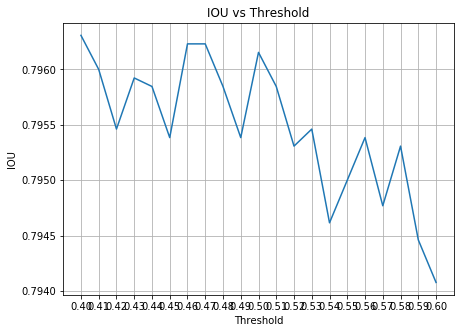

In [29]:
plt.figure(figsize=(7,5))

plt.plot(thresholds,iou_thresh)
plt.title("IOU vs Threshold")
plt.xlabel("Threshold")
plt.xticks(thresholds)
plt.ylabel("IOU")
plt.xticks('90')
plt.grid()
plt.show()

In [30]:
%%time

# saving the test predictions

name="test_predicitons/resnet_no_fold_64_batch"
np.save(name,preds_test)

CPU times: user 18.7 ms, sys: 908 ms, total: 927 ms
Wall time: 9.75 s


## Prepare Submission
We need to prepare the submission. 

In [31]:
def downsample(img):# not used
    if img.shape[0]==101:
        return img
    return resize(img, (101,101), mode='constant', 
                  preserve_range=True,clip=True,anti_aliasing=False)


def rle_encode(im):
    '''
    im: numpy array, 1-mask, 0-background
    Returns run length as string
    '''
    pixels = im.flatten(order='F')
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)


threshold=0.5
sub=sample.copy()

for index,name in tqdm.tqdm_notebook(enumerate(sub['id'].values),total=sub['id'].shape[0]):
    downsampled_img=downsample(preds_test[index].reshape(128,128))
    downsampled_img=downsampled_img>threshold
    sub.loc[index,'rle_mask']=rle_encode(downsampled_img)

print("Number of empty predictions are",sub.loc[sub['rle_mask']==""].shape[0])
sub.head()


Number of empty predictions are 7474


,id,rle_mask
0,155410d6fa,1 908 910 99 1011 98 1112 96 1213 96 1314 95 1...
1,78b32781d1,57 45 156 47 255 49 355 50 454 52 554 53 654 5...
2,63db2a476a,8017 2 8108 31 8163 1 8165 7 8204 42 8264 11 8...
3,17bfcdb967,4445 32 4546 93 4641 5561
4,7ea0fd3c88,


In [32]:
corrected_sub=sub.copy()
c=0

wrong_preds_ids=[]
for i in indextest:
    if sub.loc[i,'rle_mask']!="":
        wrong_preds_ids.append(sub['id'][i])
        
        # correcting the predictions
        corrected_sub.loc[i,'rle_mask']=""
        
        c=c+1

print(c,"predicitions are wrong")
print("After correction")
print("Number of final empty predictions are",corrected_sub.loc[corrected_sub['rle_mask']==""].shape[0])

0 predicitions are wrong
After correction
Number of final empty predictions are 7474


## SAVING THE FILE

In [33]:
# saving the file
name="resnet_2_blocks_unet_64_batch.csv"
sub.to_csv(name,index=False)
if c!=0:
    corrected_sub.to_csv("corrected"+name,index=False)
else:
    None